In [1]:
import requests
from bs4 import BeautifulSoup
import lxml

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

import numpy as np

%matplotlib inline



In [2]:
# Call for TOP 1000 papers 
# QUERY_1 = 'covid-19 OR corona virus AND (HAS_FT:Y) AND (HAS_FT:Y) AND (OPEN_ACCESS:Y)'
QUERY_2 = 'covid-19 OR corona virus disease 2019 AND (((SRC:MED OR SRC:PMC OR SRC:PPR OR SRC:CBA) NOT (PUB_TYPE:"Review")))'

URL = 'https://www.ebi.ac.uk/europepmc/webservices/rest/search?query='+QUERY_2+'&resultType=lite&cursorMark=*&pageSize=1000&format=json'
print(URL)

# call the URL request
r = requests.get(URL)
r_json = r.json()


https://www.ebi.ac.uk/europepmc/webservices/rest/search?query=covid-19 OR corona virus disease 2019 AND (((SRC:MED OR SRC:PMC OR SRC:PPR OR SRC:CBA) NOT (PUB_TYPE:"Review")))&resultType=lite&cursorMark=*&pageSize=1000&format=json


In [3]:
r_json['resultList']['result'][1]

{'id': 'PPR115458',
 'source': 'PPR',
 'doi': '10.1101/2020.02.28.20028514',
 'title': 'Risk factors related to hepatic injury in patients with corona virus disease 2019',
 'authorString': 'Li L, Li S, Xu M, Yu P, Zheng S, Duan Z, Liu J, Chen Y, Li J.',
 'pubYear': '2020',
 'pubType': 'preprint',
 'bookOrReportDetails': {'publisher': 'medRxiv', 'yearOfPublication': 2020},
 'isOpenAccess': 'N',
 'inEPMC': 'N',
 'inPMC': 'N',
 'hasPDF': 'N',
 'hasBook': 'N',
 'hasSuppl': 'N',
 'citedByCount': 0,
 'hasReferences': 'N',
 'hasTextMinedTerms': 'Y',
 'hasDbCrossReferences': 'N',
 'hasLabsLinks': 'Y',
 'hasTMAccessionNumbers': 'N',
 'firstIndexDate': '2020-03-04',
 'firstPublicationDate': '2020-03-03'}

In [4]:
# get all the open source and free to use and read papers from Europe PMC

open_acces_sentences= []

for each_pmc_id in tqdm(r_json['resultList']['result']):
    Full_TEXT_XML = 'https://www.ebi.ac.uk/europepmc/webservices/rest/'+each_pmc_id['id']+'/fullTextXML'
    r = requests.get(Full_TEXT_XML)
    soup = BeautifulSoup(r.text, 'lxml')
    
    for each_p_tag in soup.findAll('p'):
        open_acces_sentences.append(each_p_tag.text)

    

100%|██████████| 1000/1000 [03:43<00:00,  4.48it/s]


In [5]:
open_acces_sentences[1]

"The near identical gene sequences of 90 analysed cases from outside of China suggests it has likely emerged after a solitary species jump in early December 2019 from an unknown (likely mammalian) intermediate host [2].\xa0Pangolins are an endangered ant-eating mammal from which scientists in Guangzhou have shown a coronavirus with 99% homology, with a receptor binding domain identical to that of SARS-CoV-2. However, this has not been confirmed, and, in addition, the pangolin's rarity means this may not be the only mammal involved."

In [6]:
# get all the sentences that are grater than 25 in lengths
sentences = []
for each_par in tqdm(open_acces_sentences):
    for each_sentence in each_par.split('.'):
        if len(each_sentence)>25:
            sentences.append(each_sentence.strip())

100%|██████████| 7755/7755 [00:00<00:00, 386267.66it/s]


In [7]:
# import spaCY and load gene disease ner models
import spacy
from spacy import util

## Test best model performance on test set
best_model_path = '/nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/'

print("Loading from", best_model_path)
ml_annotator = util.load_model_from_path(best_model_path)

# load this model for dependency
nlp_en = spacy.load('en')

Loading from /nfs/gns/literature/Santosh_Tirunagari/GitHub/spacy_models/pretrain_exp/best/


In [16]:
# get gene and disease pairs

def get_gene_disease_pairs(sent):
    
    sent = sent.lower()
    
    GP =''
    DS = ''
    doc = ml_annotator(sent)
    
    for ent in doc.ents:
        if ent.label_ == 'GP':
            GP = ent.text
        elif ent.label_ == 'DS':
            DS = ent.text
    # give more importance to covid-19 in the sentence. My model doesnt seem to recognise covid-19 yet as a disease
    if 'covid-19' in sent.lower(): 
        DS = 'COVID-19'
    elif 'sars-cov-2' in sent.lower():
        DS = 'SARS-CoV-2'
    elif '2019-ncov' in sent.lower():
        DS = '2019-nCov'        
    
    return [GP.strip(), DS.strip()]        

In [17]:
get_gene_disease_pairs("The infection routes and pathogenesis of 2019-nCov are not fully understood by far, and the study of 2019-nCoV host cell receptor ACE2 could be valuable for the prevention and treatment of the COVID-19")

['cell receptor ace2', 'COVID-19']

In [18]:
entity_pairs = []

for i in tqdm(sentences):
    entity_pairs.append(get_gene_disease_pairs(i))

100%|██████████| 27349/27349 [01:08<00:00, 398.39it/s]


In [19]:
# extract gene
source = [i[0] for i in entity_pairs]

# extract disease
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'gene':source, 'disease':target})

In [20]:
# remove empty rows

kg_df['gene'].replace('', np.nan, inplace=True)
kg_df['disease'].replace('', np.nan, inplace=True)
kg_df.dropna(subset=['gene','disease'], inplace=True)



In [21]:
# get weights that are more than 2

new_df = kg_df.groupby(['gene','disease'])["gene"].count().reset_index(name="weight")
f_df = new_df[new_df['weight']>2]
len(new_df)

328

# Knowledge Graphs

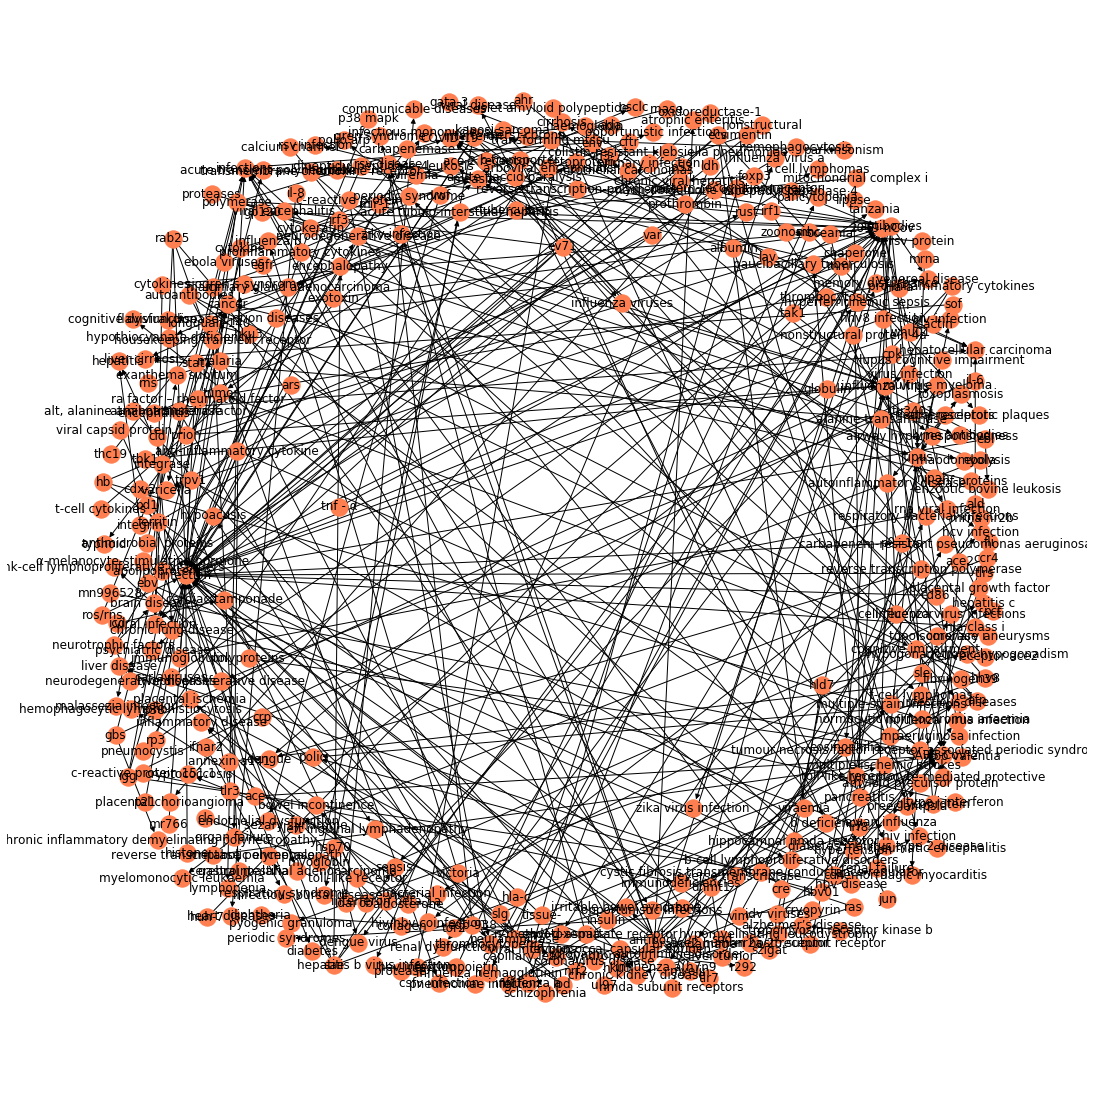

In [70]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(new_df, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

nx.draw(G, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()


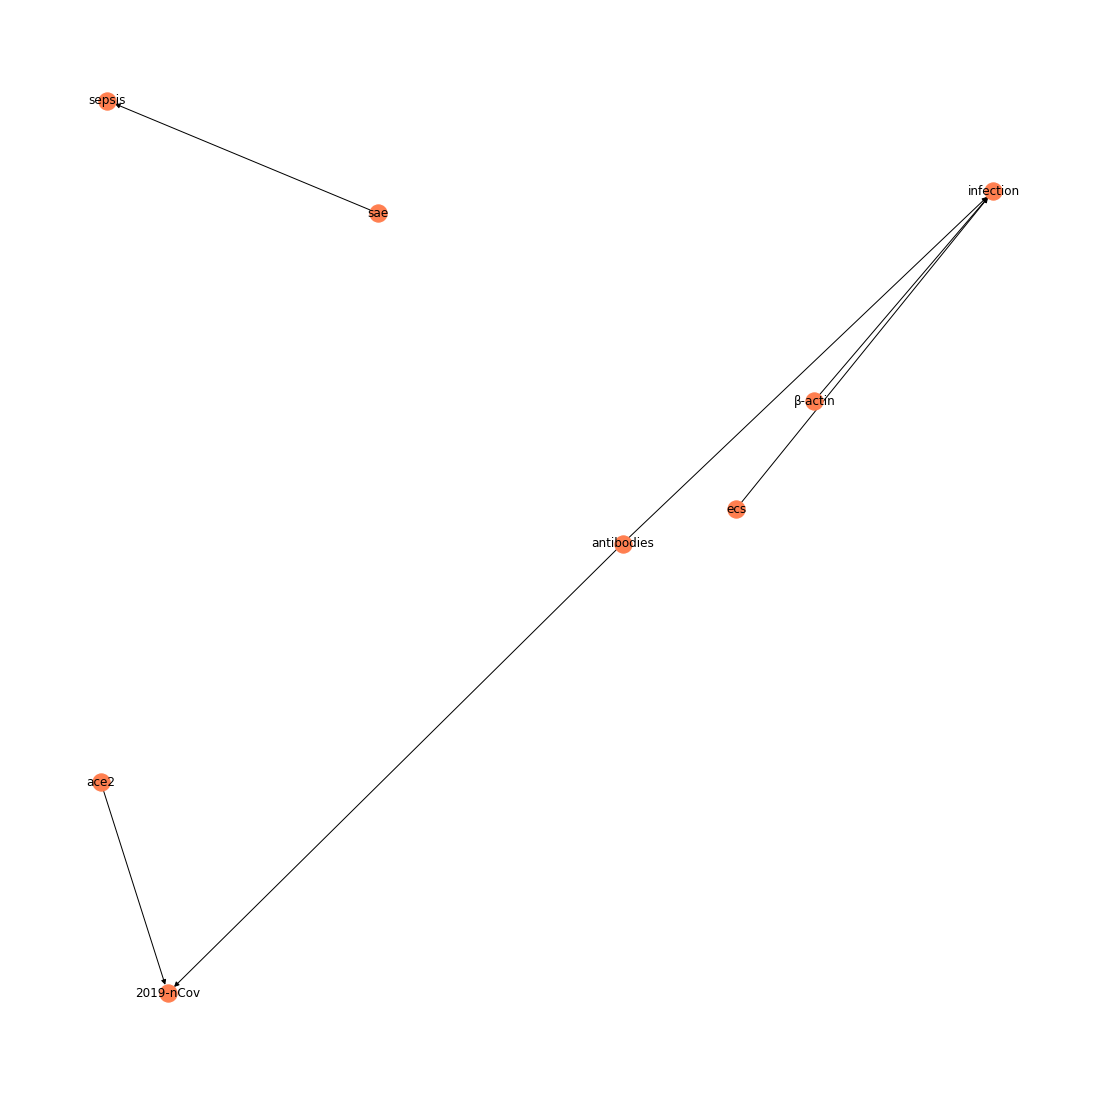

In [71]:
# Strength 2 ( 5 times occurance)
f_df_2 = new_df[new_df['weight']>2]

Gf_df_2=nx.from_pandas_edgelist(f_df_5, "gene", "disease", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(15,15))

# pos = nx.spring_layout(G)
pos = nx.fruchterman_reingold_layout(Gf_df_2, k =0.9, iterations =20)

nx.draw(Gf_df_2, 
        with_labels=True, 
        node_color='coral', 
        edge_cmap=plt.cm.Blues, 
        pos = pos)

plt.show()

In [72]:
# # Strength 6 ( more than 6 times occurance)

# f_df_5 = new_df[new_df['weight']>5]

# G=nx.from_pandas_edgelist(f_df_5, "gene", "disease", 
#                           edge_attr=True, create_using=nx.MultiDiGraph())

# plt.figure(figsize=(15,15))

# # pos = nx.spring_layout(G)
# pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

# nx.draw(G, 
#         with_labels=True, 
#         node_color='coral', 
#         edge_cmap=plt.cm.Blues, 
#         pos = pos)

# plt.show()

In [63]:
# # Covid papers
# covid_df = new_df[new_df['disease']=='covid-19']
# len(covid_df)

# # create a directed-graph from a dataframe
# G=nx.from_pandas_edgelist(covid_df, "gene", "disease", 
#                           edge_attr=True, create_using=nx.MultiDiGraph())


# plt.figure(figsize=(10,10))

# # pos = nx.spring_layout(G)
# pos = nx.fruchterman_reingold_layout(G, k =0.9, iterations =20)

# nx.draw(G, 
#         with_labels=True, 
#         node_color='coral', 
#         edge_cmap=plt.cm.Blues, 
#         pos = pos)

# plt.show()


# Save Json

In [73]:
G2 = nx.convert_node_labels_to_integers(G, first_label=0, ordering='default', label_attribute='name')

In [74]:
new_nodes_labels = dict(zip(list(G.nodes()),list(G2.nodes())))

In [75]:
from collections import Counter
influence_ = dict(Counter(list(new_df['gene'].values)+(list(new_df['disease'].values))))


In [97]:
# create node dataframe

all_genes = list(new_df['gene'].values)
all_diseases  = list(new_df['disease'].values)

nodes_ = []
for key, value in new_nodes_labels.items():
    if key in all_genes: 
        zone = 1
    elif key in all_diseases:
        zone = 2
    else:
        zone = 3
    nodes_.append((key, value, influence_[key], zone))
    
    
nodes_df = pd.DataFrame(nodes_, columns=('name', 'id', 'influence', 'zone'))

In [98]:
new_df['edge_info'] = list(G2.edges())

edges_ = []
for index,row in new_df.iterrows():
    edges_.append((row['edge_info'][0], row['edge_info'][1],row['weight']))
    
    
edges_df = pd.DataFrame(edges_, columns=('source', 'target', 'weight'))


In [99]:
import json
nodes = [{'character': u['name'], 'id': int(u['id']), 'influence':int(u['influence']),'zone':int(u['zone'])}
         for i, u in nodes_df.iterrows()]
links = [{'source': int(u['source']), 'target': int(u['target']), 'weight': int(u['weight'])+5}
         for i,u in edges_df.iterrows()]
with open('graph.json', 'w') as f:
    json.dump({'nodes': nodes, 'links': links},
              f, indent=4,)